In [81]:
%matplotlib inline
import pymc as pm
from pymc import DiscreteUniform, Exponential, deterministic, Poisson, Uniform
import numpy as np
from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

In [69]:
#data
disasters_array =   \
     np.array([ 4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                   3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                   2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0, 0,
                   1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                   0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                   3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                   0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
n_count_data = len(disasters_array)

In [70]:
#Build network model
switchpoint = DiscreteUniform('switchpoint', lower=0, upper=110, doc='Switchpoint[year]')
early_mean = Exponential('early_mean', beta=1.)
late_mean = Exponential('late_mean', beta=1.)
@deterministic(plot=False)
def rate(s=switchpoint, e=early_mean, l=late_mean):
    ''' Concatenate Poisson means '''
    out = np.empty(len(disasters_array))
    out[:s] = e
    out[s:] = l
    return out
disasters = Poisson('disasters', mu=rate, value=disasters_array, observed=True)
model = pm.Model([disasters, switchpoint, early_mean, late_mean])

In [71]:
#Run the model
M = MCMC(model)
M.sample(iter=10000, burn=1000, thin=10)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.8 sec

(array([   8.,   52.,  116.,  228.,  220.,  153.,   86.,   26.,    9.,    2.]),
 array([ 0.62168513,  0.69686398,  0.77204283,  0.84722168,  0.92240053,
         0.99757938,  1.07275822,  1.14793707,  1.22311592,  1.29829477,
         1.37347362]),
 <a list of 10 Patch objects>)

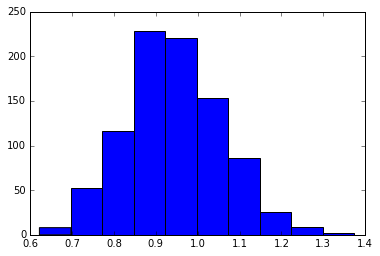

In [72]:
from pylab import hist, show
hist(M.trace('late_mean')[:])

Plotting late_mean
Plotting early_mean
Plotting switchpoint


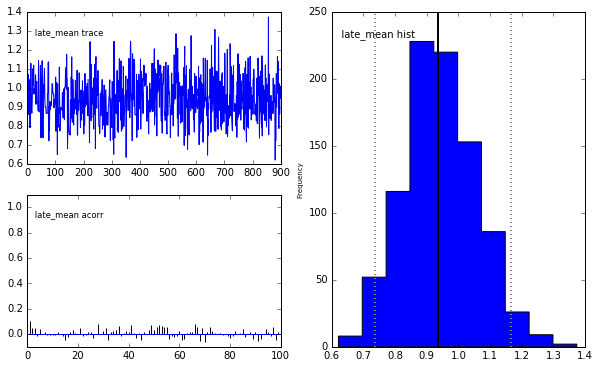

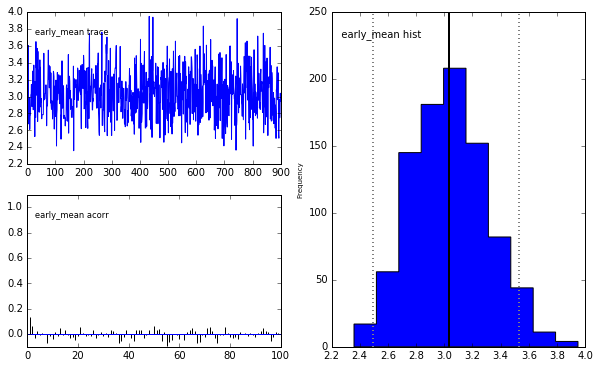

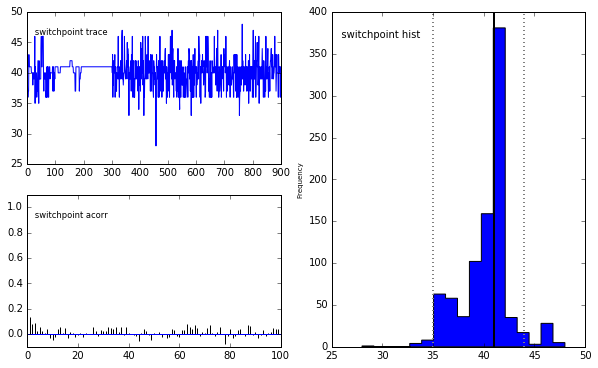

In [73]:
from pymc.Matplot import plot
plot(M)

In [74]:
early_mean_samples = M.trace('early_mean')[:]
late_mean_samples = M.trace('late_mean')[:]
switchpoint_samples = M.trace('switchpoint')[:]

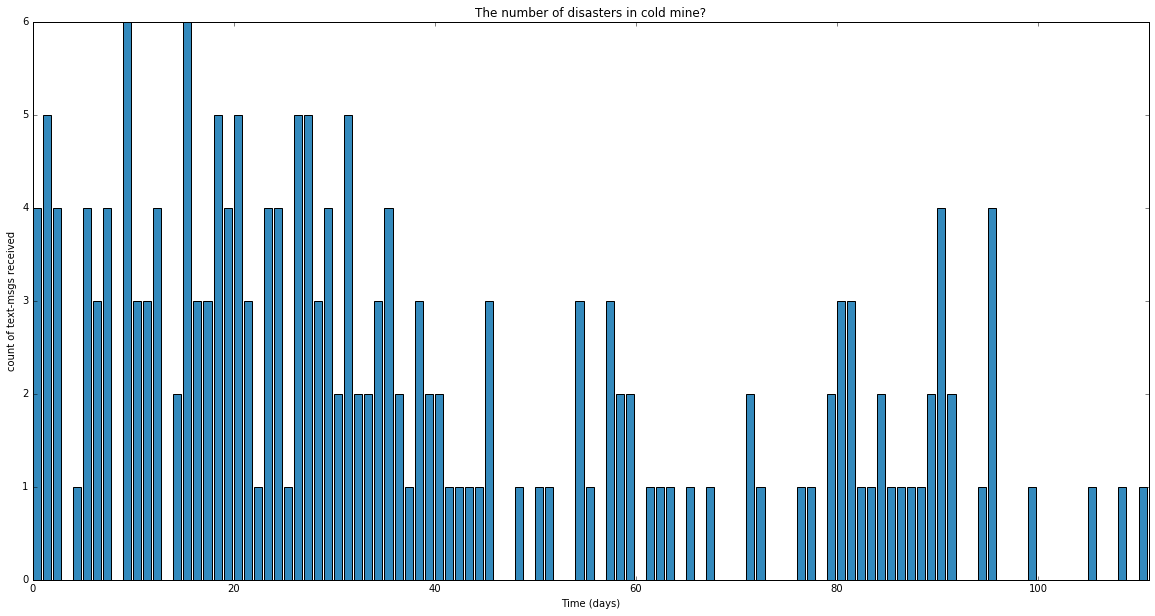

In [96]:
figsize(20, 10)
n_count_data = len(disasters_array)
plt.bar(np.arange(n_count_data), disasters_array, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("The number of disasters in cold mine?")
plt.xlim(0, n_count_data);

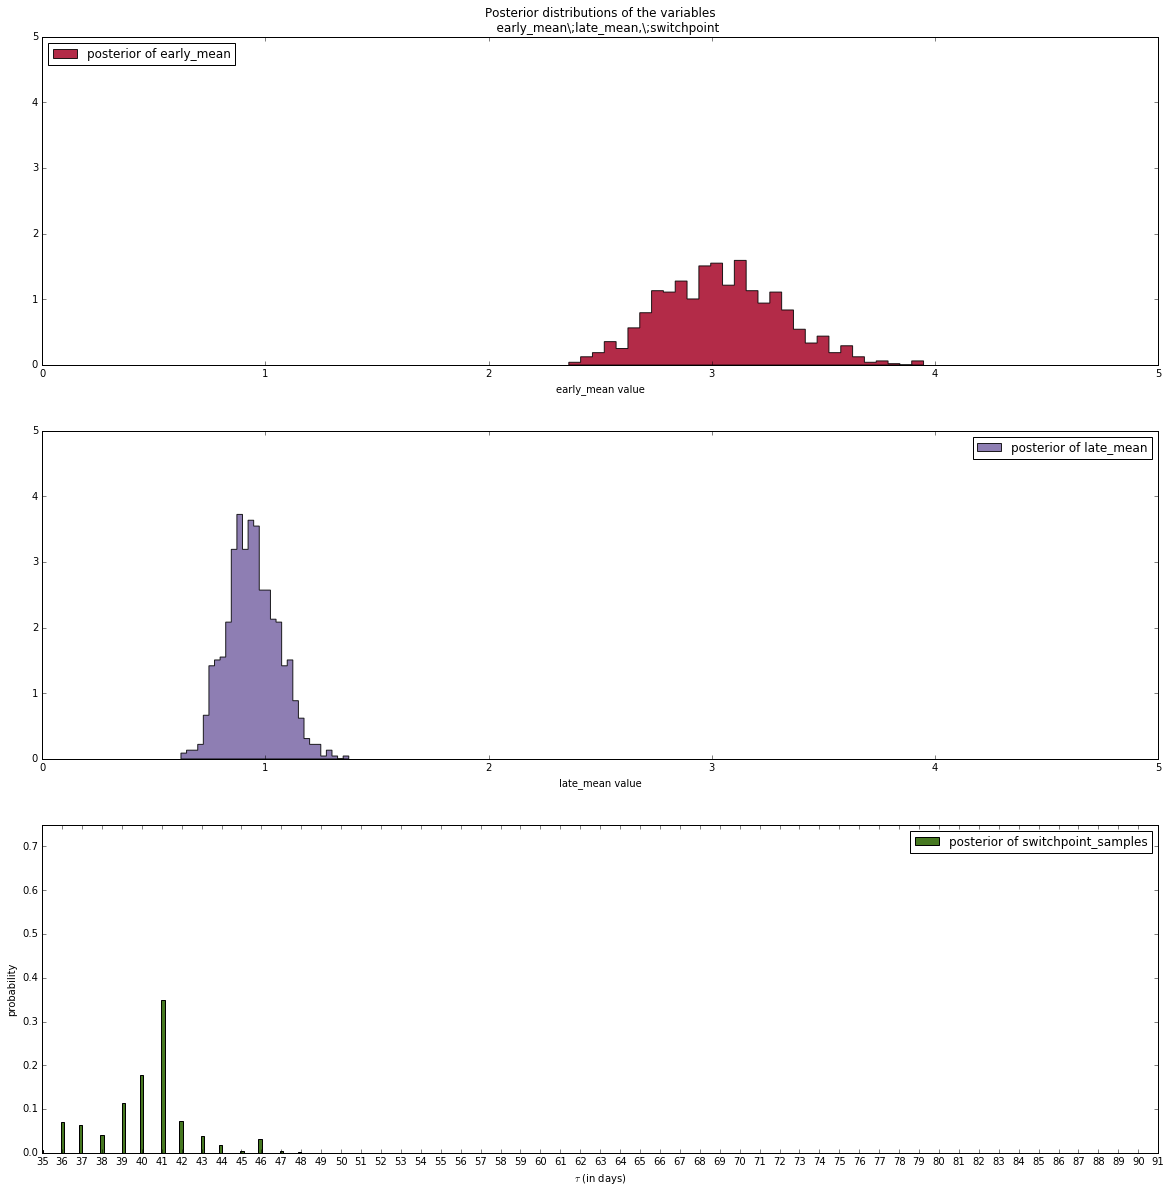

In [95]:

# histogram of the samples:
figsize(20, 20)
ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(early_mean_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of early_mean", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    early_mean\;late_mean,\;switchpoint""")
plt.xlim([0, 5])
plt.xlabel("early_mean value")
plt.ylim([0, 5])


ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(late_mean_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of late_mean", color="#7A68A6", normed=True)
plt.legend(loc="upper right")
plt.xlim([0, 5])
plt.xlabel("late_mean value")
plt.ylim([0, 5])

plt.subplot(313)
w = 1.0 / switchpoint_samples.shape[0] * np.ones_like(switchpoint_samples)
plt.hist(switchpoint_samples, bins=n_count_data, alpha=1,
         label=r"posterior of switchpoint_samples",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper right")
plt.ylim([0, .75])
plt.xlim([35, len(disasters_array) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

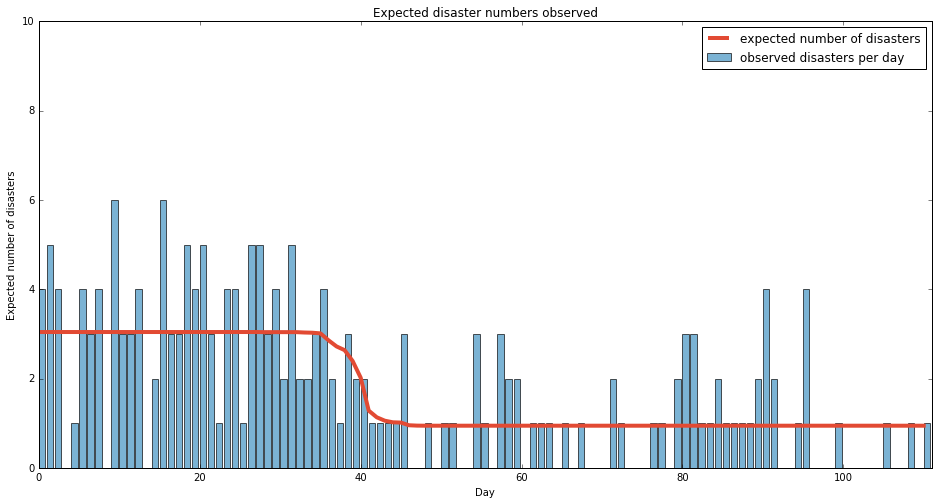

In [94]:
figsize(16, 8)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = switchpoint_samples.shape[0]
expected_disasters_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < switchpoint_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_disasters_per_day[day] = (early_mean_samples[ix].sum()
                                   + late_mean_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_disasters_per_day, lw=4, color="#E24A33",
         label="expected number of disasters")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected number of disasters")
plt.title("Expected disaster numbers observed")
plt.ylim(0, 10)
plt.bar(np.arange(len(disasters_array)), disasters_array, color="#348ABD", alpha=0.65,
        label="observed disasters per day")

plt.legend(loc="upper right");